In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os

from mokka.setup.session import Session
from mokka.postprocess.reconstruct import Reconstruction
from mokka.postprocess.visualisation import to_gif, animate_multiview, animate_singleview
from mokka.detector.mp_specs import *

## Loading the files

`kpts2d` are 2D motion captured from different camera views. They can provide some external information, such as relative speed

In [26]:
with open('output_2d_Day08_Mon10_Yr2025_Hr10_Min57_Sec44.json','rb') as f:
    k2 = json.loads(json.load(f))

In [27]:
kpts2d = np.array([[cam['frames'][f]['a']['body'] for f in range(477)] for cam in k2])
kpts2d.shape

(9, 477, 33, 3)

`kpts3d` is raw 3D motion after having triangulated 2D motions. This raw 3D will have some issues and your task is to make it better.

In [28]:
with open('footage_Day08_Mon10_Yr2025_Hr11_Min11_Sec50.json','rb') as f:
    k3 = json.load(f)

In [29]:
kpts3d = np.array(k3['frames'])
kpts3d.shape

(477, 33, 4)

## Your processing here
`kpts3d_filtered` will be your results after doing the processing. Try and make use of the information you have from `kpts2d` and `kpts3d`

In [30]:
# Global Trajectory Estimation: Camera Pose Estimation + Metric Scale Recovery + World Coordinate Alignment

# ====== Small utilities ======
def isfinite3(x):
    return np.isfinite(x[..., 0]) & np.isfinite(x[..., 1]) & np.isfinite(x[..., 2])

def linear_interp_nan_1d(a):
    idx = np.arange(a.shape[0])
    m = np.isfinite(a)
    if m.all():
        return a
    if not m.any():
        return np.zeros_like(a)
    return np.interp(idx, idx[m], a[m])

def rotation_matrix_from_vectors(a, b, eps=1e-8):
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    v = np.cross(a, b)
    c = float(np.dot(a, b))
    s = np.linalg.norm(v)
    I = np.eye(3)
    if s < eps:
        # Parallel or anti-parallel
        if c > 0.0:
            return I
        # 180 deg: rotate around an arbitrary axis orthogonal to a
        axis = np.array([1.0, 0.0, 0.0])
        if abs(a[0]) > 0.9:
            axis = np.array([0.0, 1.0, 0.0])
        axis = axis - a * np.dot(a, axis)
        axis /= (np.linalg.norm(axis) + eps)
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        return I + 2 * K @ K  # 180 deg
    vx, vy, vz = v
    K = np.array([[0, -vz, vy],
                  [vz, 0, -vx],
                  [-vy, vx, 0]])
    R = I + K + K @ K * ((1.0 - c) / (s**2 + eps))
    return R

def fit_plane_svd(P):
    # P: (N,3), returns normal n (unit) and offset d in n·x + d = 0
    c = np.mean(P, axis=0)
    Pc = P - c
    _, _, Vt = np.linalg.svd(Pc, full_matrices=False)
    n = Vt[-1]
    n = n / (np.linalg.norm(n) + 1e-8)
    d = -np.dot(n, c)
    return n, d

def apply_rtscale(X, R=None, t=None, s=1.0):
    if R is None:
        R = np.eye(3)
    if t is None:
        t = np.zeros(3)
    Xo = (R @ X.reshape(-1, 3).T).T
    Xo = s * Xo + t
    return Xo.reshape(X.shape)

def robust_person_height_z(k3):
    # k3: (T,J,3) assumed Z-up; per-frame robust height (95p - 5p)
    if k3.size == 0:
        return np.nan
    z = k3[..., 2]
    # guard NaNs
    mask = np.isfinite(z)
    zc = np.where(mask, z, np.nan)
    Hs = []
    for t in range(k3.shape[0]):
        zt = zc[t]
        zt = zt[np.isfinite(zt)]
        if zt.size < 4:
            continue
        lo, hi = np.percentile(zt, [5, 95])
        Hs.append(max(hi - lo, 1e-6))
    if len(Hs) == 0:
        return np.nan
    return float(np.median(Hs))

def yaw_from_vec_to_x(vxy):
    # vxy: 2D vector (x,y), rotate around Z to align vxy -> +X
    ang = np.arctan2(vxy[1], vxy[0])
    # Want Rz(-ang)
    c, s = np.cos(-ang), np.sin(-ang)
    Rz = np.array([[c, -s, 0],
                   [s,  c, 0],
                   [0,  0, 1]], dtype=float)
    return Rz

def principal_direction_xy(centers_xy):
    # centers_xy: (T,2)
    C = centers_xy - np.mean(centers_xy, axis=0, keepdims=True)
    if C.shape[0] < 2:
        return np.array([1.0, 0.0])
    # PCA via SVD
    U, S, Vt = np.linalg.svd(C, full_matrices=False)
    v = Vt[0, :2]
    # Ensure facing +X roughly (optional): keep as is
    return v / (np.linalg.norm(v) + 1e-8)

def stack_valid_XU(kpts3d_world, kpts2d_cam):
    # Returns stacked X (N,3), U (N,2) with finite rows
    X = kpts3d_world.reshape(-1, 3)              # (T*J,3)
    U = kpts2d_cam[..., :2].reshape(-1, 2)       # (T*J,2)
    m = np.isfinite(X).all(axis=1) & np.isfinite(U).all(axis=1)
    X = X[m]
    U = U[m]
    return X, U

def estimate_weak_perspective_camera(X, U, min_points=50):
    # X: (N,3), U: (N,2)
    if X.shape[0] < min_points:
        return None
    Xmean = X.mean(axis=0)
    Umean = U.mean(axis=0)
    Xc = X - Xmean
    Uc = U - Umean
    # Linear least squares for 2x3 M
    XtX = Xc.T @ Xc
    if np.linalg.cond(XtX) > 1e8:
        return None
    M = (Uc.T @ Xc) @ np.linalg.inv(XtX)   # (2,3)
    # Project to closest scaled-rotation (weak-perspective)
    U_s, S_s, Vt_s = np.linalg.svd(M, full_matrices=False)  # U_s:(2,2), Vt_s:(3,3)
    R2 = U_s @ Vt_s[:2, :]  # (2,3), rows orthonormal
    s_cam = float(np.mean(S_s))  # average singular values as global scale
    # Build 3x3 rotation by adding third row as cross product
    r1 = R2[0]
    r2 = R2[1]
    r3 = np.cross(r1, r2)
    # Orthonormalize
    r1 /= (np.linalg.norm(r1) + 1e-8)
    r2 /= (np.linalg.norm(r2) + 1e-8)
    r3 /= (np.linalg.norm(r3) + 1e-8)
    R = np.vstack([r1, r2, r3])  # 3x3, not necessarily a proper camera R but consistent
    t2 = Umean - s_cam * (R2 @ Xmean)  # (2,)
    t = np.array([t2[0], t2[1], 0.0])  # store as 3D with zero along z for convenience
    return dict(R=R, R2=R2, t=t, t2=t2, s=s_cam, model='weak-perspective')

# ====== 1) World Z-up by ground plane alignment ======
# Prepare a robust set of candidate ground points: bottom 5% of Z over all (T,J)
X_raw = kpts3d[..., :3].astype(float)
mask3d = isfinite3(X_raw)
if not mask3d.any():
    raise ValueError("kpts3d has no finite values.")

X_flat = X_raw[mask3d]
# Use the axis that seems 'vertical' initially by picking the axis with smallest spread of candidate ground points?
# Instead: directly fit a plane to the bottom 5% points along the third component as given (assumes rough Z).
# If Z axis is not vertical initially, plane fitting still recovers the normal.
z_all = X_flat[:, 2]
z_thresh = np.nanpercentile(z_all, 5.0)
ground_candidates = X_flat[z_all <= z_thresh + 1e-6]
if ground_candidates.shape[0] < 100:
    # fallback: use overall lowest 10%
    z_thresh = np.nanpercentile(z_all, 10.0)
    ground_candidates = X_flat[z_all <= z_thresh + 1e-6]

if ground_candidates.shape[0] >= 20:
    n, d = fit_plane_svd(ground_candidates)  # n points upward-ish
    # Force the plane normal to point upward to avoid unintended 180° flips
    if np.dot(n, np.array([0.0, 0.0, 1.0])) < 0:
        n = -n
    # Align plane normal -> +Z
    Rzup = rotation_matrix_from_vectors(n, np.array([0.0, 0.0, 1.0]))
else:
    Rzup = np.eye(3)

X_rot = apply_rtscale(X_raw, R=Rzup, t=None, s=1.0)

# Recompute ground height after rotation and shift so ground ~ z=0
Z_all = X_rot[isfinite3(X_rot)][:, 2]
if Z_all.size > 0:
    z0 = np.nanpercentile(Z_all, 5.0)  # near-ground
else:
    z0 = 0.0
t_ground = np.array([0.0, 0.0, -z0], dtype=float)
X_zup = apply_rtscale(X_rot, R=None, t=t_ground, s=1.0)

# ====== 2) Metric scale recovery (height-based) ======
TARGET_HEIGHT_M = 1.70  # adjust if subject height is known
H_est = robust_person_height_z(X_zup)
if not np.isfinite(H_est) or H_est < 1e-3:
    s_metric = 1.0
else:
    s_metric = float(np.clip(TARGET_HEIGHT_M / H_est, 0.25, 4.0))

X_metric = apply_rtscale(X_zup, R=None, t=None, s=s_metric)

# ====== 3) World coordinate alignment (heading) ======
# Use centroid trajectory to define heading; align dominant XY direction to +X
centers = np.nanmean(np.where(isfinite3(X_metric)[..., None], X_metric, np.nan), axis=1)  # (T,3)
centers = np.array([np.where(np.isfinite(centers[:, i]), centers[:, i], linear_interp_nan_1d(centers[:, i])) for i in range(3)]).T
centers_xy = centers[:, :2]
# Remove frames with NaNs after interp
centers_xy = centers_xy[np.isfinite(centers_xy).all(axis=1)]
if centers_xy.shape[0] >= 2:
    fwd_xy = principal_direction_xy(centers_xy)
    # Disambiguate PCA sign using overall displacement to avoid 180° yaw
    disp = centers_xy[-1] - centers_xy[0]
    if np.linalg.norm(disp) > 1e-6 and np.dot(fwd_xy, disp) < 0:
        fwd_xy = -fwd_xy
    R_yaw = yaw_from_vec_to_x(fwd_xy)
else:
    R_yaw = np.eye(3)

X_world = apply_rtscale(X_metric, R=R_yaw, t=None, s=1.0)

# Translate so first-frame centroid is near origin in XY
first_centroid = np.nanmean(np.where(isfinite3(X_world[0])[..., None], X_world[0], np.nan), axis=0)
if np.isfinite(first_centroid).all():
    t_xy0 = np.array([-first_centroid[0], -first_centroid[1], 0.0])
else:
    t_xy0 = np.zeros(3)
X_world = apply_rtscale(X_world, R=None, t=t_xy0, s=1.0)

c, s = np.cos(-np.pi/2), np.sin(-np.pi/2)
R_right90 = np.array([[c, -s, 0],
                      [s,  c, 0],
                      [0,  0, 1]], dtype=float)
X_world = apply_rtscale(X_world, R=R_right90, t=None, s=1.0)

APPLY_MIRROR_X = False  # flip left/right
APPLY_MIRROR_Y = False  # flip forward/back
if APPLY_MIRROR_X:
    X_world = apply_rtscale(X_world, R=np.diag([-1.0, 1.0, 1.0]), t=None, s=1.0)
if APPLY_MIRROR_Y:
    X_world = apply_rtscale(X_world, R=np.diag([1.0, -1.0, 1.0]), t=None, s=1.0)

# ====== 4) Camera Pose Estimation (weak perspective per camera) ======
camera_models = []
if 'kpts2d' in globals() and isinstance(kpts2d, np.ndarray) and kpts2d.ndim >= 4:
    # kpts2d shape expected (C,F,J,D>=2)
    C = kpts2d.shape[0]
    for c in range(C):
        X, U = stack_valid_XU(X_world, kpts2d[c])
        cam = estimate_weak_perspective_camera(X, U, min_points=50)
        camera_models.append(cam)
else:
    camera_models = []

# ====== Output ======
kpts3d_filtered = X_world  # keep variable name for downstream plotting and GIF
print(f"[GTE] Z-up aligned, metric scale ~ {s_metric:.3f}x, cameras estimated: {sum([m is not None for m in camera_models])}/{len(camera_models) if camera_models else 0}")
# Optionally expose additional artifacts:
kpts3d_world = X_world
GTE_summary = dict(scale_metric=s_metric, R_zup=Rzup, R_yaw=R_yaw, t_ground=t_ground, t_xy0=t_xy0, cameras=camera_models)

[GTE] Z-up aligned, metric scale ~ 1.110x, cameras estimated: 9/9


## Check-up Plotting

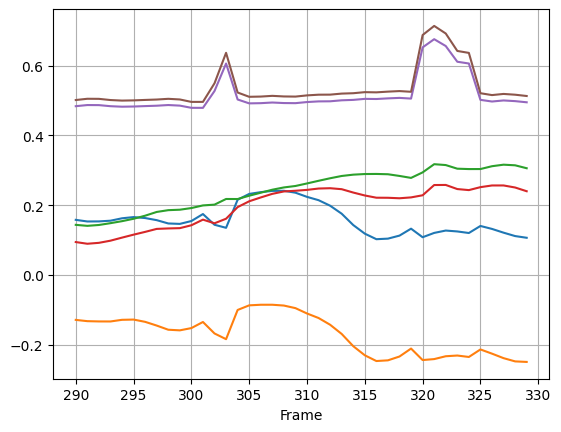

In [31]:
style = '-'
# Joint number
i = 25
# Frame range of interest
start_frame, end_frame = 290, 330

fr = slice(start_frame, end_frame)
x = np.arange(start_frame, end_frame)

_,ax = plt.subplots(1,1)
for o in range(3):
    ax.plot(x,kpts3d[fr,i,o],style)
    ax.plot(x,kpts3d_filtered[fr,i,o],style)
ax.set_xlabel('Frame')
ax.grid(True)
plt.show()

## Export output to GIF

MovieWriter imagemagick unavailable; using Pillow instead.


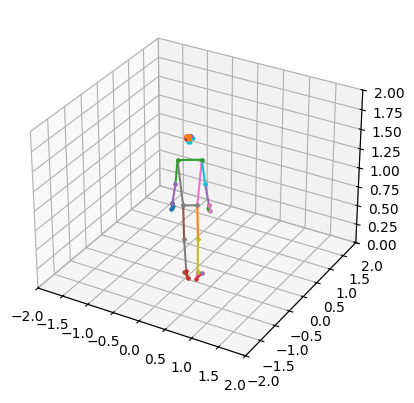

In [32]:
to_gif(kpts3d_filtered, 
       30,                      # FPS
       POSE_CONNECTIONS, 
       time.strftime("d%d_mo%m_y%Y_%Hh_%Mm_%Ss_") + 'filtered_output.gif',
       div=2                    # Display dimension width in meters
       )